In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import operator

import sys
sys.path.append("..")


try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass

from sklearn.decomposition import KernelPCA

In [2]:
def check_for_nulls(df):
    """
    Test and report number of NAs in each column of the input data frame
    :param df: pandas.DataFrame
    :return: None
    """
    for col in df.columns.values:
        num_nans = np.sum(df[col].isnull())
        if num_nans > 0:
            print('%d Nans in col %s' % (num_nans, col))
    print('New shape of df: ', df.shape)

In [5]:
# load dataset
asset_prices = pd.read_csv('spx_holdings_and_spx_closeprice.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()
n_stocks_show = 12
print('Asset prices shape', asset_prices.shape)
asset_prices.iloc[:, :n_stocks_show].head()

Asset prices shape (3493, 419)


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,32.9375,33.5625
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,32.3125,33.0000
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,32.5625,33.5000
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,32.5625,33.6875
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,32.5625,33.6250


In [9]:
print('Last column contains SPX index prices:')
asset_prices.iloc[:, -9:].head()

Last column contains SPX index prices:


,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-27,86.6178,26.3983,11.3873,65.8677,22.1921,60.9705,20.7086,12.2457,1398.56
2000-01-28,82.4218,27.4137,11.2230,60.3487,21.7558,62.3032,20.1183,12.0742,1360.16
2000-01-31,86.3181,28.2444,11.0862,62.1484,22.0533,60.6373,19.5772,12.1722,1394.46
2000-02-01,83.0212,28.7982,11.1683,67.3674,22.2120,60.4708,19.5772,12.5151,1409.28
2000-02-02,81.5226,28.6136,11.1956,68.9271,22.6483,62.4698,19.5281,12.3192,1409.12


In [7]:
check_for_nulls(asset_prices)

New shape of df:  (3493, 419)


In [10]:
asset_returns = np.log(asset_prices) - np.log(asset_prices.shift(1))
asset_returns = asset_returns.iloc[1:, :]
asset_returns.iloc[:, :n_stocks_show].head()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP
2000-01-28,-0.005495,-0.014286,-0.079188,0.000000,0.033901,-0.085294,-0.005874,-0.015751,-0.025222,-0.051287,-0.019158,-0.016902
2000-01-31,-0.027934,0.002695,0.020696,-0.033921,0.021340,-0.044402,-0.021165,-0.005306,-0.031131,-0.010183,0.007707,0.015038
2000-02-01,0.070188,0.034380,-0.034317,0.030573,0.009547,0.014654,0.047006,0.021057,0.015687,0.036155,0.000000,0.005581
2000-02-02,0.074610,0.033236,-0.014460,0.009987,0.005693,0.092861,-0.018019,-0.021057,-0.056015,0.005903,0.000000,-0.001857
2000-02-03,0.016208,-0.031506,0.044531,-0.006639,0.005654,0.119028,0.094129,0.000000,0.065054,0.034679,0.011451,0.032910


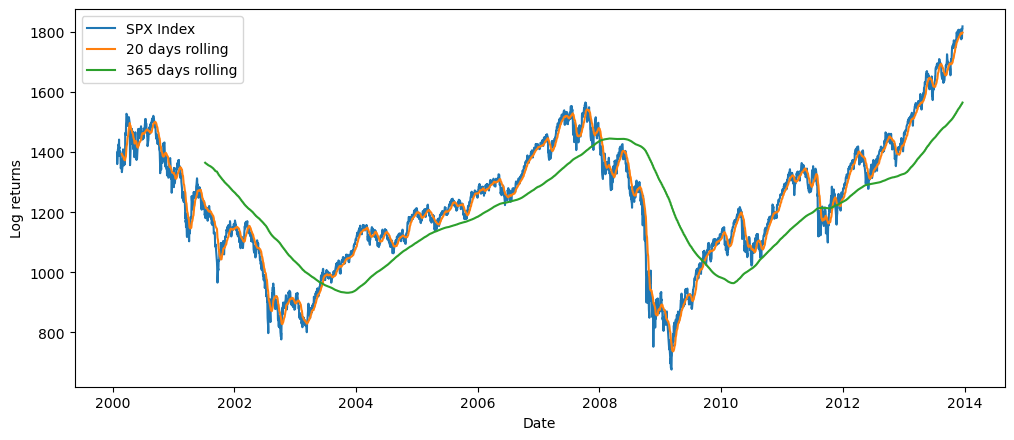

In [14]:
# Get the SPX time series. This now returns a Pandas Series object indexed by date.# Get t 
spx_index = asset_prices.loc[:, 'SPX']

short_rolling_spx = pd.core.series.Series(np.zeros(len(asset_prices.index)), index=asset_prices.index)
long_rolling_spx = short_rolling_spx

# Calculate the 20 and 365 days moving averages of log-returns

short_rolling_spx = spx_index.rolling(window=20).mean()
long_rolling_spx = spx_index.rolling(window=365).mean()



# Plot the index and rolling averages
fig=plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
ax.plot(spx_index.index, spx_index, label='SPX Index')
ax.plot(short_rolling_spx.index, short_rolling_spx, label='20 days rolling')
ax.plot(long_rolling_spx.index, long_rolling_spx, label='365 days rolling')
ax.set_xlabel('Date')
ax.set_ylabel('Log returns')
ax.legend(loc=2)
plt.show()

In [15]:
# Apply scikit-learn StandardScaler to stocks log-returns
from sklearn.preprocessing import StandardScaler

# Standardize features by removing the mean and scaling to unit variance
# Centering and scaling happen independently on each feature by computing the relevant statistics 
# on the samples in the training set. Mean and standard deviation are then stored to be used on later 
# data using the transform method.
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

log_ret_mat_std = StandardScaler().fit_transform(asset_returns.values)
log_ret_df_std = pd.DataFrame(data=log_ret_mat_std, 
                              index=asset_returns.index,
                              columns=asset_returns.columns.values) 
log_ret_df_std.iloc[:, :10].head()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK
2000-01-28,-0.177095,-0.503576,-2.684641,-0.040166,2.149514,-2.773218,-0.199237,-0.761249,-1.539968,-1.829376
2000-01-31,-0.904935,0.110571,0.665376,-1.782203,1.346264,-1.449596,-0.716880,-0.268812,-1.898412,-0.377810
2000-02-01,2.277787,1.256534,-1.179699,1.529962,0.592079,0.461992,1.590897,0.974079,0.941618,1.258580
2000-02-02,2.421231,1.215159,-0.513727,0.472721,0.345593,2.993509,-0.610369,-1.011401,-3.407901,0.190245
2000-02-03,0.526866,-1.126343,1.464752,-0.381145,0.343102,3.840506,3.186137,-0.018661,3.936335,1.206468


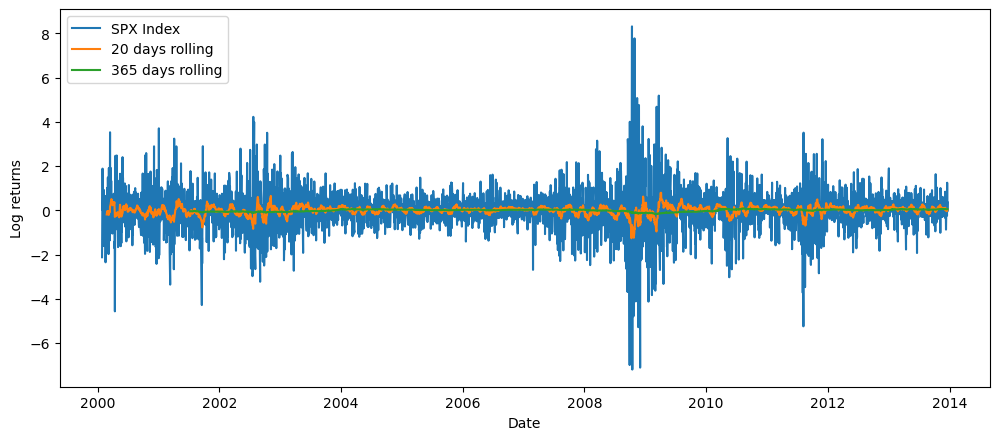

In [17]:
# Calculate the 20 and 365 days moving averages of the log-returns
short_rolling_spx = log_ret_df_std[['SPX']].rolling(window=20).mean()
long_rolling_spx = log_ret_df_std[['SPX']].rolling(window=365).mean()

# Plot the index and rolling averages
fig=plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.plot(log_ret_df_std.index, log_ret_df_std[['SPX']], label='SPX Index')
ax.plot(short_rolling_spx.index, short_rolling_spx, label='20 days rolling')
ax.plot(long_rolling_spx.index, long_rolling_spx, label='365 days rolling')
ax.set_xlabel('Date')
ax.set_ylabel('Log returns')
ax.legend(loc=2)
plt.show()

In [18]:
# Assign a label 'regime' to each date:
# 'regime' = 'benign' for all points except two intervals
# 'regime' = 'crisis_2001_2002', or
# 'regime = ', 'crisis_2007-2009'

# first assign the default value for all rows
log_ret_df_std['regime'] = 'benign'
dt_start = np.datetime64('2000-03-24T00:00:00.000000000')
dt_end = np.datetime64('2002-10-09T00:00:00.000000000')
flag_crisis_2001_2002 = np.logical_and(log_ret_df_std.index > dt_start, log_ret_df_std.index < dt_end)

dt_start = np.datetime64('2007-10-09T00:00:00.000000000')
dt_end = np.datetime64('2009-03-09T00:00:00.000000000')
flag_crisis_2007_2009 = np.logical_and(log_ret_df_std.index > dt_start, log_ret_df_std.index < dt_end)

log_ret_df_std.loc[flag_crisis_2001_2002,'regime'] = 'crisis_2001_2002'
log_ret_df_std.loc[flag_crisis_2007_2009, 'regime'] = 'crisis_2007_2009'

print('crisis_2001_2002', log_ret_df_std[log_ret_df_std.regime == 'crisis_2001_2002'].shape[0])
print('crisis_2007_2009', log_ret_df_std[log_ret_df_std.regime == 'crisis_2007_2009'].shape[0])
print(log_ret_df_std.shape)

print('Last N days of the dataset:')
log_ret_df_std.iloc[:, :10].tail()

crisis_2001_2002 635
crisis_2007_2009 354
(3492, 420)
Last N days of the dataset:


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK
2013-12-16,0.048156,0.240452,0.156457,-0.040166,0.209504,-1.308457,0.229593,0.353842,0.378619,-0.431163
2013-12-17,0.657942,0.501195,-0.180108,-0.115249,0.121412,-0.474871,0.138236,0.922656,-0.217628,0.216760
2013-12-18,0.864258,0.494531,-0.284769,0.897945,2.566273,0.747634,0.575724,1.831260,1.417926,0.549664
2013-12-19,-0.285876,0.524670,-0.415206,-0.025413,-0.169652,-0.515127,-0.082096,0.686380,0.246457,-0.183206
2013-12-20,-0.237193,-0.095901,0.250960,0.099780,-0.338791,0.610861,0.237364,-0.483890,0.404861,0.813525


In [19]:
# use data before 2012-03-26 for training, and data after it for testing

train_end = datetime.datetime(2012, 3, 26) 
df_train = log_ret_df_std[log_ret_df_std.index <= train_end].copy()
df_test = log_ret_df_std[log_ret_df_std.index > train_end].copy()
print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)

Train dataset: (3055, 420)
Test dataset: (437, 420)


In [28]:
# regress each individual stock on the market

from sklearn.linear_model import LinearRegression

# create a Linear Regression object
lm = LinearRegression()
stock_tickers = asset_returns.columns.values[:-1] # exclude SPX

# compute betas for all stocks in the dataset
R2_in_sample = [0.] * len(stock_tickers)
R2_out_sample = [0.] * len(stock_tickers)
betas = [0.] * len(stock_tickers)
alphas = [0.] * len(stock_tickers)

tuple = (0,1,2,3) 

stocks = df_train.columns.values[:-2]
for i, stock in enumerate(stocks):
    lm.fit(df_train['SPX'].shape((300, 1)), df_train[stock].shape((305, 1)))
    betas[i] = lm.coef_[0][0]
    alphas[i] = lm.intercept_[0]
    
    df_pred = lm.predict(df_train['SPX'].shape((3055, 1)))
    R2_in_sample[i] = r2_score(df_train[stock], df_pred)
    
    df_pred = lm.predict(df_test['SPX'].shape((437, 1)))
    R2_out_sample[i] = r2_score(df_test[stock].shape((437, 1)), df_pred)




TypeError: 'tuple' object is not callable

In [29]:
df_lr = pd.DataFrame({'R2 in-sample': R2_in_sample, 'R2 out-sample': R2_out_sample, 'Alpha': alphas, 'Beta': betas}, 
                     index=stock_tickers)
df_lr.head(10)

,R2 in-sample,R2 out-sample,Alpha,Beta
A,0.0,0.0,0.0,0.0
AA,0.0,0.0,0.0,0.0
AAPL,0.0,0.0,0.0,0.0
ABC,0.0,0.0,0.0,0.0
ABT,0.0,0.0,0.0,0.0
ADBE,0.0,0.0,0.0,0.0
ADI,0.0,0.0,0.0,0.0
ADM,0.0,0.0,0.0,0.0
ADP,0.0,0.0,0.0,0.0
ADSK,0.0,0.0,0.0,0.0


In [30]:
df_unexplained = df_train.loc[:, stock_tickers]

df_ = pd.DataFrame(index=df_train.index, columns=stocks)
df_ = df_.fillna(0)
df_pred = (df_.T + df_train['SPX'].values).T 
df_unexplained = df_train[stocks] - df_lr['Alpha'] - df_lr['Beta'] * df_pred




print('Unexplained log-returns of S&P 500 Index stocks', df_unexplained.shape)
print('Unexplained log-returns of S&P 500 Index stocks:')
df_unexplained.iloc[:, :10].head()

Unexplained log-returns of S&P 500 Index stocks (3055, 418)
Unexplained log-returns of S&P 500 Index stocks:


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK
2000-01-28,-0.177095,-0.503576,-2.684641,-0.040166,2.149514,-2.773218,-0.199237,-0.761249,-1.539968,-1.829376
2000-01-31,-0.904935,0.110571,0.665376,-1.782203,1.346264,-1.449596,-0.716880,-0.268812,-1.898412,-0.377810
2000-02-01,2.277787,1.256534,-1.179699,1.529962,0.592079,0.461992,1.590897,0.974079,0.941618,1.258580
2000-02-02,2.421231,1.215159,-0.513727,0.472721,0.345593,2.993509,-0.610369,-1.011401,-3.407901,0.190245
2000-02-03,0.526866,-1.126343,1.464752,-0.381145,0.343102,3.840506,3.186137,-0.018661,3.936335,1.206468


C:\Users\josep\anaconda3\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


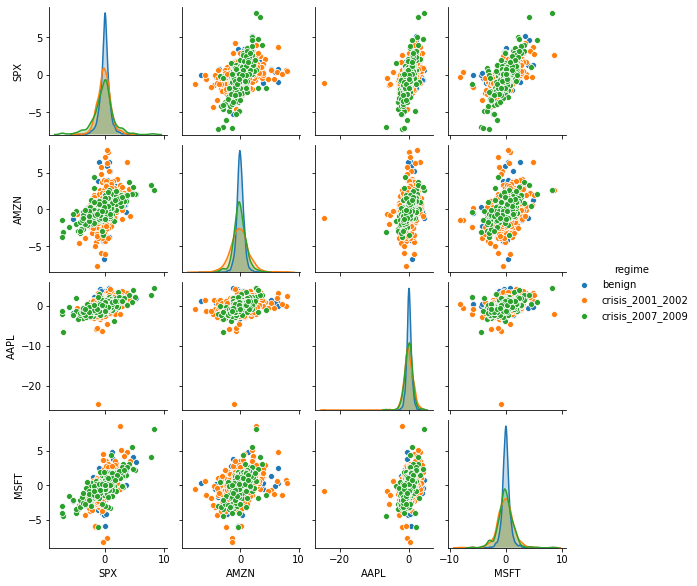

In [35]:
# Kernel PCA of Covariance Matrix of Returns
import seaborn as sns
sns.pairplot(df_train.loc[:, ['SPX', 'AMZN', 'AAPL', 'MSFT', 'regime']], 
             vars=['SPX', 'AMZN', 'AAPL', 'MSFT'], hue="regime", size=2)

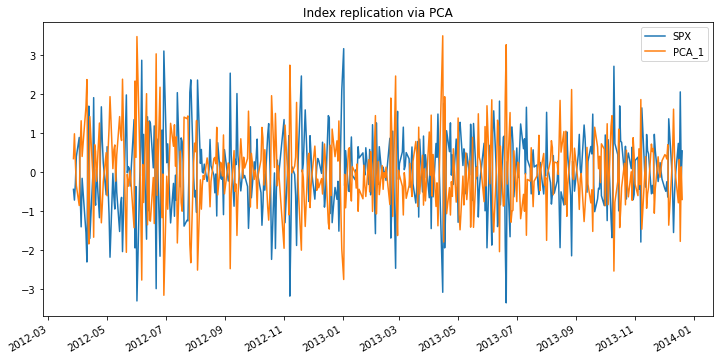

In [36]:
stock_tickers = asset_returns.columns.values[:-1]
assert 'SPX' not in stock_tickers, "By accident included SPX index"
data = df_test[stock_tickers].values

df_index_test = pd.DataFrame(data=df_test['SPX'].values, index=df_test.index, columns=['SPX'])
df_index_test['PCA_1'] = np.ones(len(df_test.index)) 


# please set random_state=42 when initializing Kernel PCA

pca = KernelPCA(n_components=1, 
                random_state=42)
df_index_test['PCA_1'] = pca.fit_transform(df_test[stock_tickers])



# draw the two plots
df_plot = df_index_test[['SPX', 'PCA_1']].apply(lambda x: (x - x.mean()) / x.std())
df_plot.plot(figsize=(12, 6), title='Index replication via PCA')

In [37]:
# Visualization with t-SNE
import time
from sklearn.manifold import TSNE

np.random.seed(42)
tsne_results = np.zeros((log_ret_df_std[stock_tickers].shape[0], 2))
perplexity = 50 
n_iter = 300
time_start = time.time()

#... please set random_state=42 when initializing TSNE
tsne = TSNE(n_components=2,
            n_iter=300,
            perplexity=50,
            random_state=42)
tsne.fit(log_ret_df_std[stock_tickers])
tsne_results = tsne.fit_transform(log_ret_df_std[stock_tickers])

In [38]:
df_tsne = pd.DataFrame({'regime': log_ret_df_std.regime.values,
                        'x-tsne': tsne_results[:,0],
                        'y-tsne': tsne_results[:,1]},
                       index=log_ret_df_std.index)
print('t-SNE (perplexity=%.0f) data:' % perplexity)
df_tsne.head(10)

t-SNE (perplexity=50) data:


,regime,x-tsne,y-tsne
2000-01-28,benign,1.445872,-12.052599
2000-01-31,benign,-2.068534,8.046645
2000-02-01,benign,-2.439835,2.500345
2000-02-02,benign,-1.323309,-0.918066
2000-02-03,benign,2.630268,9.118281
2000-02-04,benign,-0.720986,-4.110862
2000-02-07,benign,-4.998947,-6.835180
2000-02-08,benign,4.990650,2.124102
2000-02-09,benign,2.009728,-11.574594
2000-02-10,benign,-6.627170,-5.291445


In [39]:
def plot_tsne_2D(df_tsne, label_column, plot_title):
    """
    plot_tsne_2D - plots t-SNE as two-dimensional graph
    Arguments:
    label_column - column name where labels data is stored
    df_tsne - pandas.DataFrame with columns x-tsne, y-tsne
    plot_title - string
    """
    unique_labels = df_tsne[label_column].unique()
    print('Data labels:', unique_labels)
    print(df_tsne.shape)

    colors = [ 'b', 'g','r']
    markers = ['s', 'x', 'o']
    y_train = df_tsne.regime.values

    plt.figure(figsize=(8, 8))
    ix = 0
    bars = [None] * len(unique_labels)
    for label, c, m in zip(unique_labels, colors, markers):
        plt.scatter(df_tsne.loc[df_tsne[label_column]==label, 'x-tsne'], 
                    df_tsne.loc[df_tsne[label_column]==label, 'y-tsne'], 
                    c=c, label=label, marker=m, s=15)
        bars[ix] = plt.bar([0, 1, 2], [0.2, 0.3, 0.1], width=0.4, align="center", color=c)
        ix += 1

    plt.legend(bars, unique_labels)
    plt.xlabel('first dimension')
    plt.ylabel('second dimension')
    plt.title(plot_title)
    plt.grid()
    plt.show()

Data labels: ['benign' 'crisis_2001_2002' 'crisis_2007_2009']
(3492, 3)


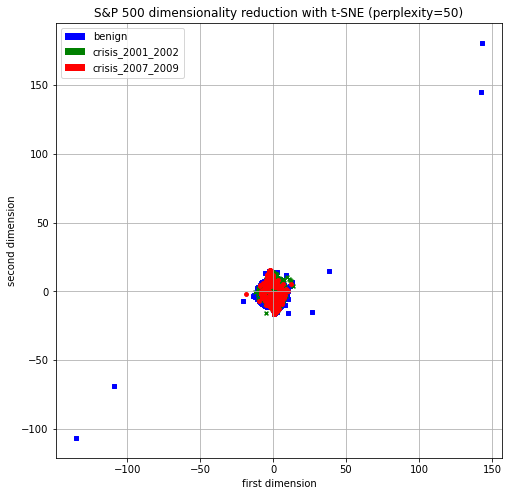

In [40]:
plot_tsne_2D(df_tsne, 'regime', 'S&P 500 dimensionality reduction with t-SNE (perplexity=%d)' % perplexity)